In [3]:
import pennylane as qml
import torch
import pandas as pd
import numpy as np
from torch.autograd import Variable
import torch.optim as optim

np.random.seed(0)
torch.manual_seed(0)

num_classes = 4
margin = 0.20
feature_size = 4
batch_size = 20
lr_adam = 0.001
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 7
total_iterations = 100
beta=0.9 # for rebalancing classes

dev = qml.device("default.qubit", wires=num_qubits)

In [5]:
# defining a basic block
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [11]:
# defining the quantum circuit, in which the number of layers depends on the number of weights taken
def circuit(weights, feat=None):
    # Encoding the features into the amplitude vector of the n qubits/wires
    # 'normalize' is set to True, to ensure the L2-norm of features equals to one
    qml.templates.embeddings.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0., normalize=True)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

# creating a variational circuit for each one-vs-all classifier, and appending to qnodes
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)
    
    
# defining a variational circuit for each one-vs-all classifier, where an additional classical bias term is added
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

In [12]:
# This function takes a number of samples and compute the average multiclass loss
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels, reweights=[]):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])], # pick circuit based on true label
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]), # weight and bias
            feature_vec
        )
        s_true = s_true.float()

        li = 0
        # Get the scores computed for this sample by the other classifiers
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j + margin - s_true)
        if(reweights.size != 0):
            li=li*reweights[int(true_labels[i])]
        loss += li

    return loss / num_samples

In [8]:
# This function takes a number of samples and return the predicted labels
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels

# This function takes a number of label-prediction pairs and return the average accuracy
def accuracy(labels, predictions):
    match = 0
    for l, p in zip(labels, predictions):
        if torch.abs(l - p) < 1e-5:
            match = match + 1
    match = match / labels.shape[0]
    return match

In [9]:
# Load up the data
def load_and_process_data():
    # converting strings to numericals
    df = pd.read_csv("scaled_feature_df.csv")
    data=df.to_numpy()
    unique_elements, counts_elements = np.unique(data[:,-1], return_counts=True)
    reweights=(1 - beta)/(1 - np.power(beta,counts_elements))
    reweights=reweights/np.sum(reweights)*len(unique_elements)
    
    X = torch.tensor(data[:, 0:feature_size])
#     print("First X sample, original  :", X[0])

#     # For understanding only: mimic the normalization of each input
#     normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
#     X_norm = X / normalization.reshape(len(X), 1)
#     print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(data[:, -1])
    return X, Y, reweights

# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train.float(), feat_vecs_test.float(), Y_train.float(), Y_test.float()

Num params:  129
Iter:     1 | Cost: 0.6782775 | Acc train: 0.2651515 | Acc test: 0.2159091 
Iter:     2 | Cost: 0.6780660 | Acc train: 0.2670455 | Acc test: 0.2215909 
Iter:     3 | Cost: 0.8442037 | Acc train: 0.2670455 | Acc test: 0.2215909 
Iter:     4 | Cost: 0.5908712 | Acc train: 0.2670455 | Acc test: 0.2102273 
Iter:     5 | Cost: 0.6232549 | Acc train: 0.2689394 | Acc test: 0.2159091 
Iter:     6 | Cost: 0.5798373 | Acc train: 0.2708333 | Acc test: 0.2159091 
Iter:     7 | Cost: 0.5679749 | Acc train: 0.2651515 | Acc test: 0.2102273 
Iter:     8 | Cost: 0.6779219 | Acc train: 0.2670455 | Acc test: 0.2215909 
Iter:     9 | Cost: 0.6265469 | Acc train: 0.2632576 | Acc test: 0.2215909 
Iter:    10 | Cost: 0.6214342 | Acc train: 0.2594697 | Acc test: 0.2159091 
Iter:    11 | Cost: 0.5440501 | Acc train: 0.2651515 | Acc test: 0.2159091 
Iter:    12 | Cost: 0.6423606 | Acc train: 0.2613636 | Acc test: 0.2102273 
Iter:    13 | Cost: 0.6137627 | Acc train: 0.2632576 | Acc test: 0.2045

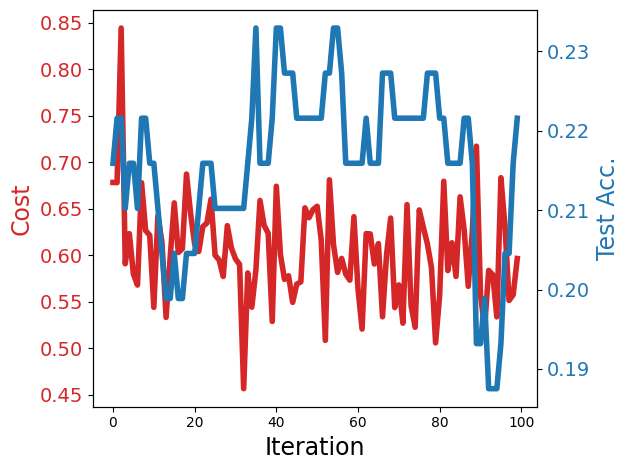

In [13]:
def training(features, Y, reweights=[]):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters, with Gaus(0, 0.1) distribution
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch, reweights=reweights)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# now run the training algorithm and plot the results
features, Y, reweights = load_and_process_data()
costs, train_acc, test_acc = training(features, Y, reweights=reweights)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()